In [1]:
# Please note that as some high-volume airports did not appear on the open-sky dataset, some of my
# "top 5" graphs contain only 3 lines of data. 

In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import datetime
from matplotlib.pyplot import figure
import geopandas as gpd
from keplergl import KeplerGl
from snowflake.connector import connect
from snowflake.connector import DictCursor
import pyarrow.parquet as pq
import os
from dotenv import load_dotenv
import numpy as np

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)

/Users/olivianystrom/opt/anaconda3/lib/python3.8/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (8.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [3]:
load_dotenv()
snowflake_password = os.getenv('snowflake_password')
snowflake_user = os.getenv('snowflake_user')

In [4]:
def retrieve_conn():
    return connect(
        warehouse='COMPUTE_WH',
        account='st51563.us-central1.gcp', 
        database='PC_DBT_DB',
        schema='FLIGHT_TRACKING',
        user=snowflake_user,
        password=snowflake_password,
)

In [5]:
cnx = retrieve_conn()

In [27]:
#Pulling datasets from Snowflake (these were manipulated in DBT)
arrivals_departures = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.ARRIVALS_DEPARTURES", cnx) 
top_5_Africa = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.TOP_5_AFRICA ORDER BY year_month ASC", cnx) 
top_5_Asia = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.TOP_5_ASIA ORDER BY year_month ASC", cnx) 
top_5_europe = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.TOP_5_EUROPEAN_AIRPORTS_PER_MONTH ORDER BY year_month ASC", cnx) 
top_5_South_America = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.TOP_5_SOUTH_AMERICA ORDER BY year_month ASC", cnx) 
top_5_USA = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.TOP_5_USA_FLIGHTS_PER_MONTH ORDER BY year_month ASC", cnx) 
USA_wtc = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.USA_WTC ORDER BY year_month ASC", cnx) 
ALL_H_M = pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION_MARTS.ALL_H_M ORDER BY year_month ASC", cnx) 


<ipython-input-37-329a5caa5301>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


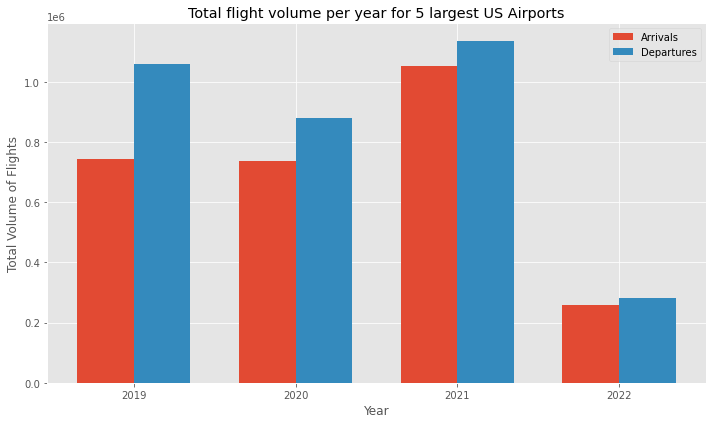

In [37]:
# Shows totals for arrivals and departures by year in every airport that had data available through
# the Open Sky covid dataset
arrivals_departures_5USA = arrivals_departures[arrivals_departures['AIRPORT'].isin(['KORD', 'KATL', 'KDFW', 'KDEN', 'KLAX'])] 

labels = ['2019', '2020', '2021', '2022']
arrivals =   [np.sum(arrivals_departures_5USA['ARRIVALS_2019']), 
              np.sum(arrivals_departures_5USA['ARRIVALS_2020']), 
              np.sum(arrivals_departures_5USA['ARRIVALS_2021']), 
              np.sum(arrivals_departures_5USA['ARRIVALS_2022'])] 
departures = [np.sum(arrivals_departures_5USA['DEPARTURES_2019']),
              np.sum(arrivals_departures_5USA['DEPARTURES_2020']),
              np.sum(arrivals_departures_5USA['DEPARTURES_2021']), 
              np.sum(arrivals_departures_5USA['DEPARTURES_2022'])] 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, arrivals, width, label='Arrivals')
rects2 = ax.bar(x + width/2, departures, width, label='Departures')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Year')
ax.set_ylabel('Total Volume of Flights')
ax.set_title('Total flight volume per year for 5 largest US Airports')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels)

fig.tight_layout()

plt.show()

In [8]:
#Adding Year_Month column to all datasets
top_5_USA['YEAR_MONTH'] = pd.to_datetime(top_5_USA['YEAR_MONTH'])
top_5_europe['YEAR_MONTH'] = pd.to_datetime(top_5_europe['YEAR_MONTH'])
top_5_Africa['YEAR_MONTH'] = pd.to_datetime(top_5_Africa['YEAR_MONTH'])
top_5_Asia['YEAR_MONTH'] = pd.to_datetime(top_5_Asia['YEAR_MONTH'])
top_5_South_America['YEAR_MONTH'] = pd.to_datetime(top_5_South_America['YEAR_MONTH'])


In [9]:
#Naming Xticks and dates
X_ticks = ['Jan 2019', 'Feb 2019', 'Mar 2019', 'Apr 2019', 'May 2019',
       'Jun 2019', 'Jul 2019', 'Aug 2019', 'Sep 2019', 'Oct 2019',
       'Nov 2019', 'Dec 2019', 'Jan 2020', 'Feb 2020', 'Mar 2020',
       'Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020',
       'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020', 'Jan 2021',
       'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021',
       'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021', 'Nov 2021',
       'Dec 2021', 'Jan 2022', 'Feb 2022', 'Mar 2022']
dates = top_5_USA['YEAR_MONTH'].unique()


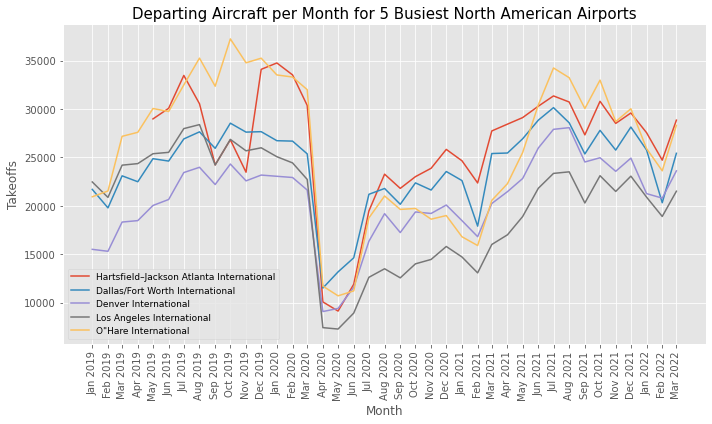

In [10]:
#top 5 NA airports

f, ax = plt.subplots()
plt.plot(top_5_USA[top_5_USA['ORIGIN'] == 'KATL']['YEAR_MONTH'], 
         top_5_USA[top_5_USA['ORIGIN'] == 'KATL']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_USA[top_5_USA['ORIGIN'] == 'KDFW']['YEAR_MONTH'], 
         top_5_USA[top_5_USA['ORIGIN'] == 'KDFW']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_USA[top_5_USA['ORIGIN'] == 'KDEN']['YEAR_MONTH'], 
         top_5_USA[top_5_USA['ORIGIN'] == 'KDEN']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_USA[top_5_USA['ORIGIN'] == 'KLAX']['YEAR_MONTH'], 
         top_5_USA[top_5_USA['ORIGIN'] == 'KLAX']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_USA[top_5_USA['ORIGIN'] == 'KORD']['YEAR_MONTH'], 
         top_5_USA[top_5_USA['ORIGIN'] == 'KORD']['TAKEOFFS_PER_MONTH'])

plt.ylabel('Takeoffs')
plt.xlabel('Month')
ax.set_title('Departing Aircraft per Month for 5 Busiest North American Airports', fontsize = 15)
# ax.grid('on')

ax.set_xticks(dates)
plt.xticks(rotation = 90)
ax.set_xticklabels(X_ticks)
ax.legend(['Hartsfield–Jackson Atlanta International','Dallas/Fort Worth International', 
           'Denver International', 'Los Angeles International', 
           'O"Hare International'] , prop={'size': 9})

plt.tight_layout()
plt.savefig('NA_takeoffs.png')

In [20]:
fuel_price = pd.read_csv("/Users/olivianystrom/Desktop/Springboard/Capstone 3/U.S._Gulf_Coast_Kerosene-Type_Jet_Fuel_Spot_Price_FOB_Daily.csv", on_bad_lines='skip')
fuel_price['_date'] = pd.to_datetime(fuel_price['_date'])
fuel_price = fuel_price.set_index(['_date'])
fuel_price_monthly = fuel_price.groupby([pd.Grouper(freq='M')]).aggregate(avg_price=('dollars_per_gallon', 'mean'))


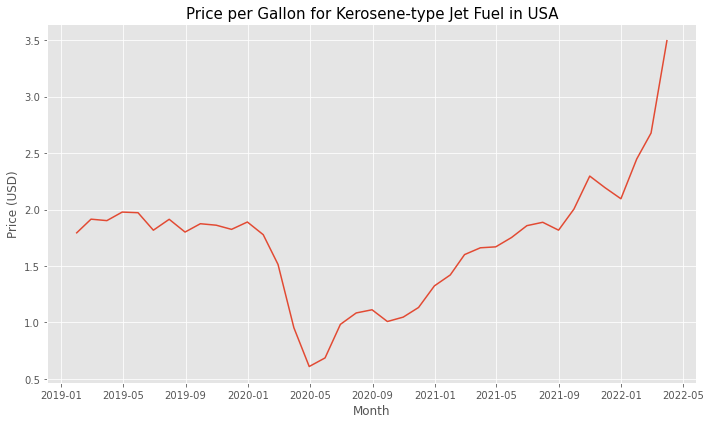

In [12]:
f, ax = plt.subplots()
plt.plot(fuel_price_monthly.loc['2019-01-01':'2022-03-31'].index, 
         fuel_price_monthly.loc['2019-01-01':'2022-04-01']['avg_price'])

plt.ylabel('Price (USD)')
plt.xlabel('Month')


plt.tight_layout()
plt.savefig('Fuel_prices_over_time.png')


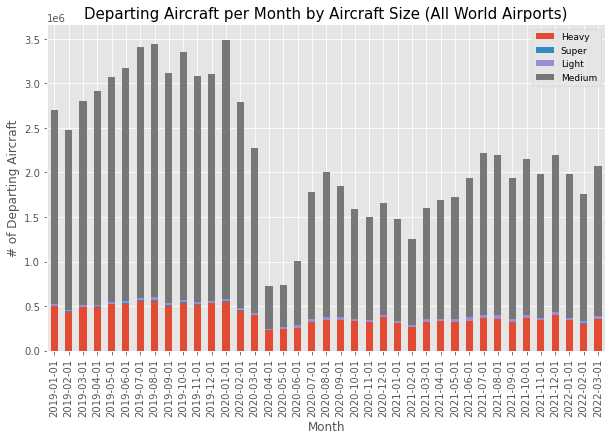

In [13]:
# plotting aircraft size over time with stacked bar graphs
fig = ALL_H_M.pivot(index='YEAR_MONTH', columns='WTC', values='TAKEOFFS_PER_MONTH').plot.bar(stacked=True)


plt.ylabel('# of Departing Aircraft')
plt.xlabel('Month')
plt.title('Departing Aircraft per Month by Aircraft Size (All World Airports)', fontsize = 15)

# plt.xticks(dates)
# plt.xticks(rotation = 90)
# plt.xticklabels(X_ticks)
plt.legend(['Heavy','Super','Light','Medium'] , prop={'size': 9})

# plt.tight_layout()
plt.savefig('NA_H_M_takeoffs.png')

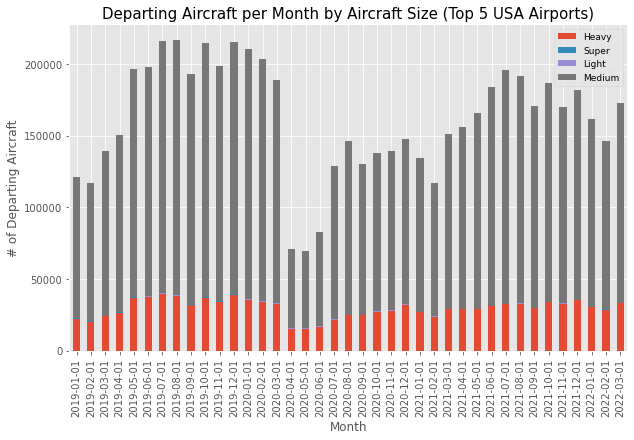

In [29]:
# plotting aircraft size over time with stacked bar graphs for top 5 USA airports
fig = USA_wtc.pivot(index='YEAR_MONTH', columns='WTC', values='TAKEOFFS_PER_MONTH').plot.bar(stacked=True)


plt.ylabel('# of Departing Aircraft')
plt.xlabel('Month')
plt.title('Departing Aircraft per Month by Aircraft Size (Top 5 USA Airports)', fontsize = 15)

# plt.xticks(dates)
# plt.xticks(rotation = 90)
# plt.xticklabels(X_ticks)
plt.legend(['Heavy','Super','Light','Medium'] , prop={'size': 9})

# plt.tight_layout()
plt.savefig('USA_wtc_takeoffs.png')

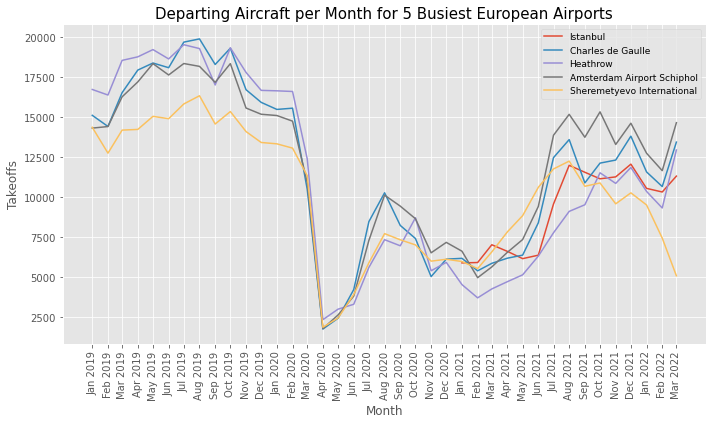

In [14]:
# --Istanbul LTFM, Charles de Gaulle Airport LFPG, Heathrow Airport EGLL, 
# Amsterdam Airport Schiphol EHAM, Sheremetyevo International Airport UUEE
dates = top_5_europe['YEAR_MONTH'].unique()
f, ax = plt.subplots()
plt.plot(top_5_europe[top_5_europe['ORIGIN'] == 'LTFM']['YEAR_MONTH'], 
         top_5_europe[top_5_europe['ORIGIN'] == 'LTFM']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_europe[top_5_europe['ORIGIN'] == 'LFPG']['YEAR_MONTH'], 
         top_5_europe[top_5_europe['ORIGIN'] == 'LFPG']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_europe[top_5_europe['ORIGIN'] == 'EGLL']['YEAR_MONTH'], 
         top_5_europe[top_5_europe['ORIGIN'] == 'EGLL']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_europe[top_5_europe['ORIGIN'] == 'EHAM']['YEAR_MONTH'], 
         top_5_europe[top_5_europe['ORIGIN'] == 'EHAM']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_europe[top_5_europe['ORIGIN'] == 'UUEE']['YEAR_MONTH'], 
         top_5_europe[top_5_europe['ORIGIN'] == 'UUEE']['TAKEOFFS_PER_MONTH'])

plt.ylabel('Takeoffs')
plt.xlabel('Month')
ax.set_title('Departing Aircraft per Month for 5 Busiest European Airports', fontsize = 15)
# ax.grid('on')

ax.set_xticks(dates)
plt.xticks(rotation = 90)
ax.set_xticklabels(X_ticks)
ax.legend(['Istanbul', 'Charles de Gaulle', 
           'Heathrow', 'Amsterdam Airport Schiphol', 
           'Sheremetyevo International'] , prop={'size': 9})

plt.tight_layout()
plt.savefig('Europe_Takeoffs.png')

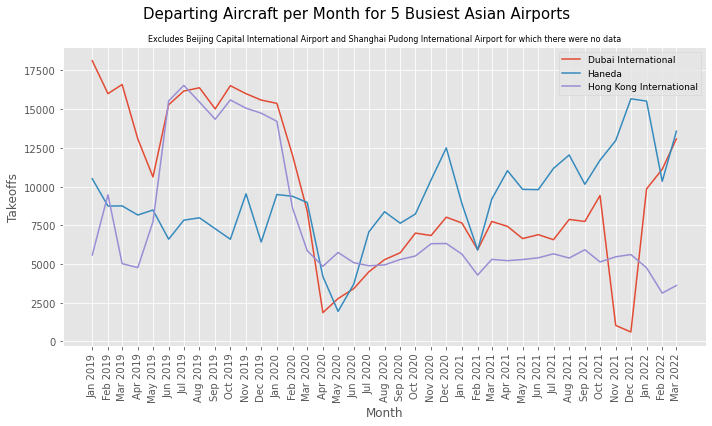

In [15]:
# --Beijing Capital International Airport ZBAA, Dubai International Airport OMDB, 
# Haneda Airport RJTT, Hong Kong International Airport VHHH, 
# Shanghai Pudong International Airport ZSPD
dates = top_5_Asia['YEAR_MONTH'].unique()
f, ax = plt.subplots()
plt.plot(top_5_Asia[top_5_Asia['ORIGIN'] == 'OMDB']['YEAR_MONTH'], 
         top_5_Asia[top_5_Asia['ORIGIN'] == 'OMDB']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_Asia[top_5_Asia['ORIGIN'] == 'RJTT']['YEAR_MONTH'], 
         top_5_Asia[top_5_Asia['ORIGIN'] == 'RJTT']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_Asia[top_5_Asia['ORIGIN'] == 'VHHH']['YEAR_MONTH'], 
         top_5_Asia[top_5_Asia['ORIGIN'] == 'VHHH']['TAKEOFFS_PER_MONTH'])


plt.ylabel('Takeoffs')
plt.xlabel('Month')
plt.suptitle('Departing Aircraft per Month for 5 Busiest Asian Airports', fontsize = 15)
plt.title('Excludes Beijing Capital International Airport and Shanghai Pudong International Airport for which there were no data', fontsize = 8)
# ax.grid('on')

ax.set_xticks(dates)
plt.xticks(rotation = 90)
ax.set_xticklabels(X_ticks)
ax.legend(['Dubai International', 
           'Haneda', 'Hong Kong International'] , prop={'size': 9})

plt.tight_layout()
plt.savefig('Asia_Takeoffs.png')

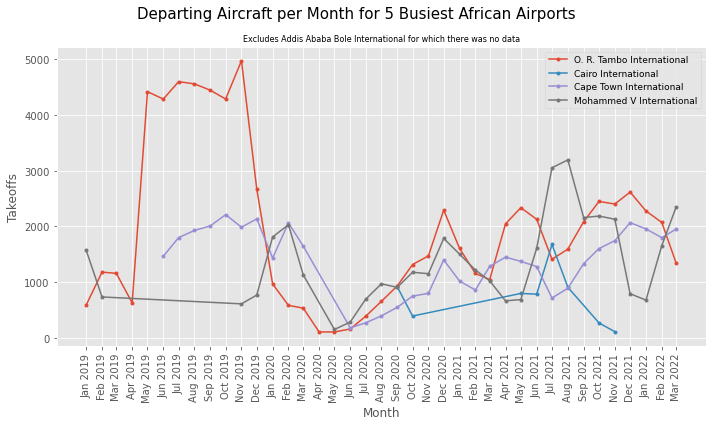

In [24]:
# -- O. R. Tambo International Airport FAOR, Cairo International Airport HECA, 
# Addis Ababa Bole International Airport HAAB, Cape Town International Airport FACT, 
# Mohammed V International Airport GMMN
dates = top_5_Africa['YEAR_MONTH'].unique()
f, ax = plt.subplots()
plt.plot(top_5_Africa[top_5_Africa['ORIGIN'] == 'FAOR']['YEAR_MONTH'], 
         top_5_Africa[top_5_Africa['ORIGIN'] == 'FAOR']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
plt.plot(top_5_Africa[top_5_Africa['ORIGIN'] == 'HECA']['YEAR_MONTH'], 
         top_5_Africa[top_5_Africa['ORIGIN'] == 'HECA']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
# plt.plot(top_5_Africa[top_5_Africa['ORIGIN'] == 'HAAB']['YEAR_MONTH'], 
#          top_5_Africa[top_5_Africa['ORIGIN'] == 'HAAB']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_Africa[top_5_Africa['ORIGIN'] == 'FACT']['YEAR_MONTH'], 
         top_5_Africa[top_5_Africa['ORIGIN'] == 'FACT']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
plt.plot(top_5_Africa[top_5_Africa['ORIGIN'] == 'GMMN']['YEAR_MONTH'], 
         top_5_Africa[top_5_Africa['ORIGIN'] == 'GMMN']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')

plt.ylabel('Takeoffs')
plt.xlabel('Month')
plt.suptitle('Departing Aircraft per Month for 5 Busiest African Airports', fontsize = 15)
plt.title('Excludes Addis Ababa Bole International for which there was no data', fontsize = 8)
# ax.grid('on')

ax.set_xticks(dates)
plt.xticks(rotation = 90)
ax.set_xticklabels(X_ticks)
ax.legend(['O. R. Tambo International', 'Cairo International', 
           'Cape Town International', 
           'Mohammed V International'] , prop={'size': 9})

plt.tight_layout()
plt.savefig('Africa_Takeoffs.png')

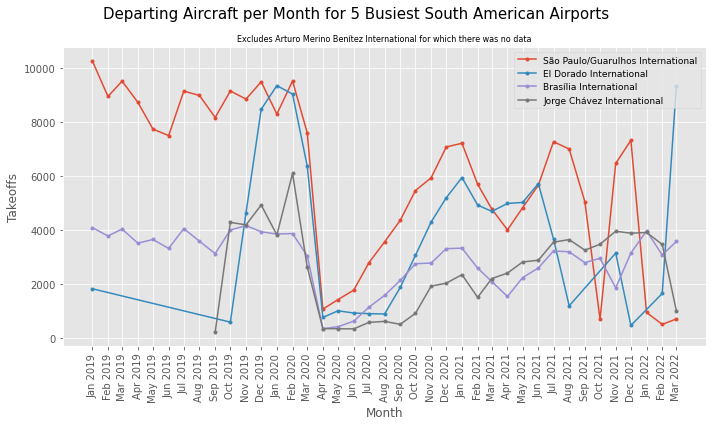

In [26]:
# --São Paulo/Guarulhos International Airport SBGR, El Dorado International Airport SKBO,
# Arturo Merino Benítez International Airport SCEL, Brasília International Airport SBBR, 
# Jorge Chávez International Airport SPJC
dates = top_5_South_America['YEAR_MONTH'].unique()
f, ax = plt.subplots()
plt.plot(top_5_South_America[top_5_South_America['ORIGIN'] == 'SBGR']['YEAR_MONTH'], 
         top_5_South_America[top_5_South_America['ORIGIN'] == 'SBGR']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
plt.plot(top_5_South_America[top_5_South_America['ORIGIN'] == 'SKBO']['YEAR_MONTH'], 
         top_5_South_America[top_5_South_America['ORIGIN'] == 'SKBO']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
# plt.plot(top_5_South_America[top_5_South_America['ORIGIN'] == 'SCEL']['YEAR_MONTH'], 
#          top_5_South_America[top_5_South_America['ORIGIN'] == 'SCEL']['TAKEOFFS_PER_MONTH'])
plt.plot(top_5_South_America[top_5_South_America['ORIGIN'] == 'SBBR']['YEAR_MONTH'], 
         top_5_South_America[top_5_South_America['ORIGIN'] == 'SBBR']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')
plt.plot(top_5_South_America[top_5_South_America['ORIGIN'] == 'SPJC']['YEAR_MONTH'], 
         top_5_South_America[top_5_South_America['ORIGIN'] == 'SPJC']['TAKEOFFS_PER_MONTH'], ls='-', marker='.')

plt.ylabel('Takeoffs')
plt.xlabel('Month')
plt.suptitle('Departing Aircraft per Month for 5 Busiest South American Airports', fontsize = 15)
plt.title('Excludes Arturo Merino Benítez International for which there was no data', fontsize = 8)
# ax.grid('on')

ax.set_xticks(dates)
plt.xticks(rotation = 90)
ax.set_xticklabels(X_ticks)
ax.legend(['São Paulo/Guarulhos International', 'El Dorado International', 
           'Brasília International', 
           'Jorge Chávez International'] , prop={'size': 9})

plt.tight_layout()
plt.savefig('South_America_Takeoffs.png')

In [18]:
open('/Users/olivianystrom/Desktop/Springboard/Capstone 3/Live_Flight_Data.csv')
df =  pd.read_sql("SELECT * FROM PC_DBT_DB.PRODUCTION.STG_LIVE_FLIGHT_TRACKING", cnx) 


In [19]:
#current locations of aircraft according to most recent data pull from API
kepler_map = KeplerGl(height = 550, data={'Airplane Data': df})
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Airplane Data':        ICAO24  CALLSIGN ORIGIN_COUNTRY  LAST_CONTACT  LONGITUDE  LATITUDE  \
0…